In [1]:
!pip install --upgrade pip
!pip install --upgrade seaborn
!pip install --upgrade tensorflow
!pip install --upgrade wget


# Paper Rock Scissors Classification
## Feature Extraction and Fine-Tuning


## Feature Extraction Using a Pretrained Model

One thing that is commonly done in computer vision is to take a model trained on a very large dataset, run it on your own, smaller dataset, and extract the intermediate representations (features) that the model generates. These representations are frequently informative for your own computer vision task, even though the task may be quite different from the problem that the original model was trained on. This versatility and repurposability of convnets is one of the most interesting aspects of deep learning.

In our case, we will use the [Inception V3 model](https://arxiv.org/abs/1512.00567) developed at Google, and pre-trained on [ImageNet](http://image-net.org/), a large dataset of web images (1.4M images and 1000 classes). This is a powerful model; let's see what the features that it has learned can do for our cat vs. dog problem.

First, we need to pick which intermediate layer of Inception V3 we will use for feature extraction. A common practice is to use the output of the very last layer before the `Flatten` operation, the so-called "bottleneck layer." The reasoning here is that the following fully connected layers will be too specialized for the task the network was trained on, and thus the features learned by these layers won't be very useful for a new task. The bottleneck features, however, retain much generality.

Let's instantiate an Inception V3 model preloaded with weights trained on ImageNet:


In [1]:
import os
import tensorflow
from tensorflow.keras import layers
from tensorflow.keras import Model
from matplotlib import pyplot as plt

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import decode_predictions
from tensorflow.keras.applications.inception_v3 import preprocess_input

from  tensorflow.keras.preprocessing.image import  load_img
from  tensorflow.keras.preprocessing.image import  img_to_array
from matplotlib.image import imread
import seaborn as sns

import random


import tensorflow as tf

Now let's download the weights:

In [2]:
os_type = "windows"
# os_type = "linux"

In [3]:
# if os_type == "linux" :
#     !wget --no-check-certificate \
#         https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
#         -O ./tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
# elif os_type == "windows" :
#     # Windows Version
#     !python -m wget https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 -o ./tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

In [6]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-07-29 14:46:21--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Résolution de storage.googleapis.com (storage.googleapis.com)... 66.102.1.128, 173.194.76.128, 74.125.140.128, ...
Connexion vers storage.googleapis.com (storage.googleapis.com)|66.102.1.128|:443... connecté.
requête HTTP transmise, en attente de la réponse... 200 OK
Taille : 87910968 (84M) [application/x-hdf]
Enregistre : «/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5»

/tmp/inception_v3_w 100%[===================>]  83,84M  10,9MB/s    ds 7,6s    

2022-07-29 14:46:29 (11,0 MB/s) - «/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5» enregistré [87910968/87910968]



In [7]:
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(
    input_shape=(150, 150, 3), include_top=False, weights=None)
pre_trained_model.load_weights(local_weights_file)

In [8]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

 batch_normalization_10 (BatchN  (None, 16, 16, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 16, 16, 32)  96          ['conv2d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_5 (Activation)      (None, 16, 16, 64)   0           ['batch_normalization_5[0][0]']  
                                                                                                  
 activation_7 (Activation)      (None, 16, 16, 64)   0           ['batch_normalization_7[0][0]']  
                                                                                                  
 activatio

 conv2d_20 (Conv2D)             (None, 16, 16, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 16, 16, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_normalization_20 (BatchN  (None, 16, 16, 48)  144         ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_23 (BatchN  (None, 16, 16, 96)  288         ['conv2d_23[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

                                                                                                  
 conv2d_34 (Conv2D)             (None, 7, 7, 128)    98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 7, 7, 128)   384         ['conv2d_34[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_34 (Activation)     (None, 7, 7, 128)    0           ['batch_normalization_34[0][0]'] 
                                                                                                  
 conv2d_35 (Conv2D)             (None, 7, 7, 128)    114688      ['activation_34[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 activation_44 (Activation)     (None, 7, 7, 160)    0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 7, 7, 160)    179200      ['activation_44[0][0]']          
                                                                                                  
 batch_normalization_45 (BatchN  (None, 7, 7, 160)   480         ['conv2d_45[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_45 (Activation)     (None, 7, 7, 160)    0           ['batch_normalization_45[0][0]'] 
                                                                                                  
 conv2d_41

 batch_normalization_55 (BatchN  (None, 7, 7, 160)   480         ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 7, 7, 160)    0           ['batch_normalization_55[0][0]'] 
                                                                                                  
 conv2d_51 (Conv2D)             (None, 7, 7, 160)    122880      ['mixed5[0][0]']                 
                                                                                                  
 conv2d_56 (Conv2D)             (None, 7, 7, 160)    179200      ['activation_55[0][0]']          
                                                                                                  
 batch_normalization_51 (BatchN  (None, 7, 7, 160)   480         ['conv2d_51[0][0]']              
 ormalizat

 conv2d_61 (Conv2D)             (None, 7, 7, 192)    147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 7, 7, 192)    258048      ['activation_65[0][0]']          
                                                                                                  
 batch_normalization_61 (BatchN  (None, 7, 7, 192)   576         ['conv2d_61[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_66 (BatchN  (None, 7, 7, 192)   576         ['conv2d_66[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 7, 7, 192)   576         ['conv2d_74[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_70 (Activation)     (None, 7, 7, 192)    0           ['batch_normalization_70[0][0]'] 
                                                                                                  
 activation_74 (Activation)     (None, 7, 7, 192)    0           ['batch_normalization_74[0][0]'] 
                                                                                                  
 conv2d_71 (Conv2D)             (None, 3, 3, 320)    552960      ['activation_70[0][0]']          
          

                                                                                                  
 activation_82 (Activation)     (None, 3, 3, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 3, 3, 384)    0           ['batch_normalization_83[0][0]'] 
                                                                                                  
 batch_normalization_84 (BatchN  (None, 3, 3, 192)   576         ['conv2d_84[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_76 (Activation)     (None, 3, 3, 320)    0           ['batch_normalization_76[0][0]'] 
                                                                                                  
 mixed9_0 

 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 3, 3, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 (Concatenate)         (None, 3, 3, 768)    0           ['activation_87[0][0]',          
                                                                  'activation_88[0][0]']          
                                                                                                  
 concatenate_1 (Concatenate)    (None, 3, 3, 768)    0           ['activation_91[0][0]',          
                                                                  'activation_92[0][0]']          
                                                                                                  
 activatio

By specifying the `include_top=False` argument, we load a network that doesn't include the classification layers at the top—ideal for feature extraction.

Let's make the model non-trainable, since we will only use it for feature extraction; we won't update the weights of the pretrained model during training.

In [9]:
for layer in pre_trained_model.layers:
  layer.trainable = False

The layer we will use for feature extraction in Inception v3 is called `mixed7`. It is not the bottleneck of the network, but we are using it to keep a sufficiently large feature map (7x7 in this case). (Using the bottleneck layer would have resulting in a 3x3 feature map, which is a bit small.) Let's get the output from `mixed7`:

In [10]:
last_layer = pre_trained_model.get_layer('mixed7')
last_layer.output
# print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output
last_output

<KerasTensor: shape=(None, 7, 7, 768) dtype=float32 (created by layer 'mixed7')>

Now let's stick a fully connected classifier on top of `last_output`:

In [11]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
outputs = layers.Dense(3, activation='softmax')(x)


# Configure and compile the model
inputs = pre_trained_model.input
model = Model(inputs, outputs)
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.0001),
              metrics=['accuracy'])

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

 batch_normalization_10 (BatchN  (None, 16, 16, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 16, 16, 32)  96          ['conv2d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_5 (Activation)      (None, 16, 16, 64)   0           ['batch_normalization_5[0][0]']  
                                                                                                  
 activation_7 (Activation)      (None, 16, 16, 64)   0           ['batch_normalization_7[0][0]']  
                                                                                                  
 activatio

 conv2d_20 (Conv2D)             (None, 16, 16, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 16, 16, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_normalization_20 (BatchN  (None, 16, 16, 48)  144         ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_23 (BatchN  (None, 16, 16, 96)  288         ['conv2d_23[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

                                                                                                  
 conv2d_34 (Conv2D)             (None, 7, 7, 128)    98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 7, 7, 128)   384         ['conv2d_34[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_34 (Activation)     (None, 7, 7, 128)    0           ['batch_normalization_34[0][0]'] 
                                                                                                  
 conv2d_35 (Conv2D)             (None, 7, 7, 128)    114688      ['activation_34[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 activation_44 (Activation)     (None, 7, 7, 160)    0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 7, 7, 160)    179200      ['activation_44[0][0]']          
                                                                                                  
 batch_normalization_45 (BatchN  (None, 7, 7, 160)   480         ['conv2d_45[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_45 (Activation)     (None, 7, 7, 160)    0           ['batch_normalization_45[0][0]'] 
                                                                                                  
 conv2d_41

 batch_normalization_55 (BatchN  (None, 7, 7, 160)   480         ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 7, 7, 160)    0           ['batch_normalization_55[0][0]'] 
                                                                                                  
 conv2d_51 (Conv2D)             (None, 7, 7, 160)    122880      ['mixed5[0][0]']                 
                                                                                                  
 conv2d_56 (Conv2D)             (None, 7, 7, 160)    179200      ['activation_55[0][0]']          
                                                                                                  
 batch_normalization_51 (BatchN  (None, 7, 7, 160)   480         ['conv2d_51[0][0]']              
 ormalizat

 conv2d_61 (Conv2D)             (None, 7, 7, 192)    147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 7, 7, 192)    258048      ['activation_65[0][0]']          
                                                                                                  
 batch_normalization_61 (BatchN  (None, 7, 7, 192)   576         ['conv2d_61[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_66 (BatchN  (None, 7, 7, 192)   576         ['conv2d_66[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

For examples and data preprocessing, let's use the same files and `train_generator` as we did in Exercise 2.

In [14]:
import os
import zipfile

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# local_zip = '/tmp/cats_and_dogs_filtered.zip'
# zip_ref = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall('/tmp')
# zip_ref.close()

# Define our example directories and files
base_dir = './rpc'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training rock pictures
train_rock_dir = os.path.join(train_dir, 'rock')

# Directory with our training paper pictures
train_paper_dir = os.path.join(train_dir, 'paper')

# Directory with our training scissors pictures
train_scissors_dir = os.path.join(train_dir, 'scissors')

# Directory with our validation cat pictures
validation_rock_dir = os.path.join(validation_dir, 'rock')

# Directory with our validation paper pictures
validation_paper_dir = os.path.join(validation_dir, 'paper')

# Directory with our validation scissors pictures
validation_scissors_dir = os.path.join(validation_dir, 'scissors')

train_rock_fnames = os.listdir(train_rock_dir)
train_paper_fnames = os.listdir(train_paper_dir)
train_scissors_fnames = os.listdir(train_scissors_dir)


# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir, # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=3,
        class_mode='categorical')

Found 2520 images belonging to 3 classes.
Found 33 images belonging to 3 classes.


Finally, let's train the model using the features we extracted. We'll train on all 2000 images available, for 2 epochs, and validate on all 1,000 validation images.

In [15]:
history = model.fit(
      train_generator,
#       train_generator.repeat(),
      steps_per_epoch=20,
      epochs=2,
      validation_data=validation_generator,
      validation_steps=5,
      verbose=2)

Epoch 1/2
20/20 - 20s - loss: 1.2527 - accuracy: 0.7025 - val_loss: 0.2383 - val_accuracy: 0.9333 - 20s/epoch - 997ms/step
Epoch 2/2
20/20 - 15s - loss: 0.2471 - accuracy: 0.9025 - val_loss: 0.2025 - val_accuracy: 0.8667 - 15s/epoch - 735ms/step


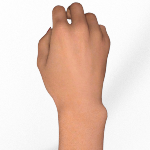

In [14]:
# mug_personalise = './data/mug/mug_personalise.jpg'
# paper = './rpc/test/paper/testpaper01-00.png'
#scissors = './rpc/test/scissors/testscissors01-10.png'
rock = './rpc/test/rock/testrock01-10.png'


# Redimension
# VGG a été entraîné sur des images (224, 224) d'où l'importance de transformer les images à prédire vers cette size 
# image = load_img(mug_personalise)
image = load_img(rock, target_size=(150, 150))

image

In [15]:
import pandas as pd

In [16]:
# Convertir NumPy array
image = img_to_array(image)
# image.shape     #  (224, 224, 3)
# image


# Préparation VGG
# Affichage de l'image, la couleur devient Bleu ; soustraire la moyenne des pixels RGB
image_pr = preprocess_input(image)
# image_pr
# image_pr.shape 
tf.keras.preprocessing.image.array_to_img(image_pr)


# Mise bon shape # (1, 150, 150, 3) : 
# Tensor rank 4 (#axis): `samples`, `rows`, `columns`, `channels`
image_pr = image_pr.reshape((1, image_pr.shape[0], image_pr.shape[1], image_pr.shape[2]))
image_pr.shape
# image_pr

(1, 150, 150, 3)

In [17]:
proba = model.predict(image_pr)
labels = ['paper', 'rock', 'scissors']
proba_df = pd.DataFrame({'proba':proba[0],'labels':labels}).sort_values('proba', ascending=False)
# proba_df.columns = ['proba']
# proba_df.sort_values('proba', ascending=False)
# Dimension ?
# proba.shape

# proba
proba_df

1/1 [==============================] - 1s 547ms/step


,proba,labels
1,0.993421,rock
0,0.004491,paper
2,0.002088,scissors


C:\Users\Thoma\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


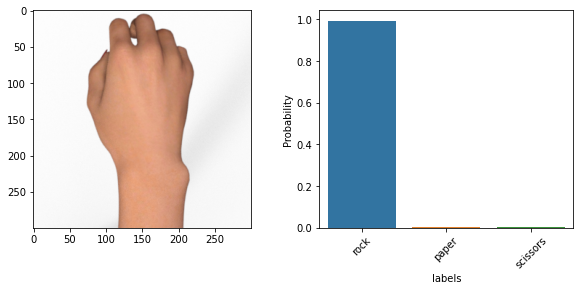

In [18]:
# Interprétation proba
# Proba -> class label
# most_likely = decode_predictions(proba, top=3)
# print(most_likely)
# most_likely = pd.DataFrame(pd.DataFrame(most_likely).T[0].values.tolist(), columns=['id', 'label', 'proba'])
# most_likely


plt.figure(figsize=(10 , 4))

plt.subplot(1,2,1)
# ./data/mug/mug_exotiq_pr_tromper_le_modele.jpg
image = imread('./rpc/test/rock/testrock01-10.png')
# image = imread('./data/mug/mug_exotiq_pr_tromper_le_modele.jpg')
plt.imshow(image);

plt.subplot(1,2,2)
p = sns.barplot(proba_df['labels'], proba_df['proba'])
plt.ylabel("Probability");
p.set_xticklabels(p.get_xticklabels(), rotation=45);

# label = decode_predictions(proba, top=3)
# label = pd.DataFrame(pd.DataFrame(label).T[0].values.tolist())

# Top 5 : 
# print("5 best :")
# print(label)
# print()

# Top 1 : 
# print("meilleure prédiction = " ,  label[0][0][1])
# print("proba = " ,  label[0][0][2])

In [19]:
len(train_generator)

126

You can see that we reach a validation accuracy of 88–90% very quickly. This is much better than the small model we trained from scratch.

# Game

In [20]:
def get_image_rps(chemin):
    rock = './rpc/test/scissors/testscissors01-10.png'

    # Redimension
    # VGG a été entraîné sur des images (224, 224) d'où l'importance de transformer les images à prédire vers cette size 
    # image = load_img(mug_personalise)
    image = load_img(chemin, target_size=(150, 150))

    # Convertir NumPy array
    image_array = img_to_array(image)


    # Préparation VGG
    # Affichage de l'image, la couleur devient Bleu ; soustraire la moyenne des pixels RGB
    image_pr = preprocess_input(image_array)

    tf.keras.preprocessing.image.array_to_img(image_pr)


    # Mise bon shape # (1, 150, 150, 3) : 
    # Tensor rank 4 (#axis): `samples`, `rows`, `columns`, `channels`
    image_pr = image_pr.reshape((1, image_pr.shape[0], image_pr.shape[1], image_pr.shape[2]))
    image_pr.shape
    proba = model.predict(image_pr)
    proba_df = pd.DataFrame(proba).T.sort_values(0, ascending=False)
    proba_df.columns = ['proba']
    proba_df = proba_df.rename(index={0:"Papier",1:"Pierre",2:"Ciseaux"})
    proba_df.sort_values('proba', ascending=False)
    
    
    return {'image':image,'dataframe':proba_df}

In [21]:
def random_img(verbose = 0):
    random_folder=random.choice(os.listdir("./rpc/test"))
    if verbose == 1 :
        print(random_folder)
    random_file= random.choice(os.listdir("./rpc/test/"+random_folder))
    if verbose == 1 : 
        print(random_file)
    return f'./rpc/test/{random_folder}/{random_file}'

In [22]:
def game(verbose = 0):
    game = {}
    score_j1 = 0
    score_j2 = 0
    
    j1 = ''
    j2 = ''
    
    tour = 0
    
    while(score_j1<3 and score_j2<3):
        tour += 1
        
        s_verbose = 0
        
        if verbose == 2:
            verbose = 1
            s_verbose = 1
        
        j1_image_path = random_img(s_verbose)
        j2_image_path = random_img(s_verbose)
        
        j1 = get_image_rps(j1_image_path)
        j2 = get_image_rps(j2_image_path)
        
        if verbose == 1 :
            display(j1['dataframe'])
            display(j2['dataframe'])
        
        if(j1['dataframe'].idxmax()['proba'] == "Papier"):
            if(j2['dataframe'].idxmax()['proba'] == "Ciseaux"):
                score_j2 += 1
            elif (j2['dataframe'].idxmax()['proba'] == "Pierre"):
                score_j1 += 1
        elif(j1['dataframe'].idxmax()['proba'] == "Pierre"):
            if(j2['dataframe'].idxmax()['proba'] == "Ciseaux"):
                score_j1 += 1
            elif (j2['dataframe'].idxmax()['proba'] == "Papier"):
                score_j2 += 1
        else :
            if(j2['dataframe'].idxmax()['proba'] == "Pierre"):
                score_j2 += 1
            elif (j2['dataframe'].idxmax()['proba'] == "Papier"):
                score_j1 += 1
        
        game[tour-1] = {
            'j1_choice' : j1['dataframe'].idxmax()['proba'],
            'j2_choice' : j2['dataframe'].idxmax()['proba'],
            'j1_image' : j1['image'],
            'j2_image' : j2['image'],
            'j1_image_path' : j1_image_path,
            'j2_image_path' : j2_image_path,
            'j1_score' : score_j1,
            'j2_score' : score_j2,
            'tour' : tour
        }
    
    return game
        

In [23]:
def lecture_game(verbose = 0):
    my_game = game(verbose)
    
    last_score_j1 = 0
    last_score_j2 = 0
    
    for i in range (0,len(my_game)):
        print()
        print("============================================================")
        print(f"tour n°{my_game[i]['tour']}")
        print("----------------------------- Joueur 1 -------------------------------")
        print(f"Choix : {my_game[i]['j1_choice']}")
        print(f"Chemin de l'image & image : {my_game[i]['j1_image_path']}")
        display(my_game[i]['j1_image'])
        print()
        print("----------------------------- Joueur 2 -------------------------------")
        print(f"Choix : {my_game[i]['j2_choice']}")
        print(f"Chemin de l'image & image : {my_game[i]['j2_image_path']}")
        display(my_game[i]['j2_image'])
        print()
        print("----------------------------- Résultat du tour -------------------------------")
        if(last_score_j1 < my_game[i]['j1_score'] and last_score_j2 == my_game[i]['j2_score']):
            print(f"Victoire du joueur 1, score : [j1 : {my_game[i]['j1_score']}] [j2 : {my_game[i]['j2_score']}]")
        elif (last_score_j1 == my_game[i]['j1_score'] and last_score_j2 < my_game[i]['j2_score']):
            print(f"Victoire du joueur 2, score : [j1 : {my_game[i]['j1_score']}] [j2 : {my_game[i]['j2_score']}]")
        else :
                print(f"Egalité ! Score : [j1 : {my_game[i]['j1_score']}] [j2 : {my_game[i]['j2_score']}]")
        last_score_j1 = my_game[i]['j1_score']
        last_score_j2 = my_game[i]['j2_score']
        
        

1/1 [==============================] - 0s 41ms/step


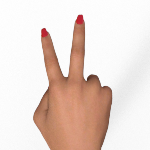

,proba
Ciseaux,0.962101
Pierre,0.023229
Papier,0.014671


proba    Ciseaux
dtype: object

In [24]:
my_image = get_image_rps(random_img())
display(my_image['image'])
display(my_image['dataframe'])
display(my_image['dataframe'].idxmax())

In [25]:
my_game = game()
display(my_game)

1/1 [==============================] - 0s 36ms/step


{0: {'j1_choice': 'Pierre',
  'j2_choice': 'Pierre',
  'j1_image': <PIL.Image.Image image mode=RGB size=150x150>,
  'j2_image': <PIL.Image.Image image mode=RGB size=150x150>,
  'j1_image_path': './rpc/test/paper/testpaper03-07.png',
  'j2_image_path': './rpc/test/rock/testrock04-09.png',
  'j1_score': 0,
  'j2_score': 0,
  'tour': 1},
 1: {'j1_choice': 'Ciseaux',
  'j2_choice': 'Pierre',
  'j1_image': <PIL.Image.Image image mode=RGB size=150x150>,
  'j2_image': <PIL.Image.Image image mode=RGB size=150x150>,
  'j1_image_path': './rpc/test/scissors/testscissors03-19.png',
  'j2_image_path': './rpc/test/rock/testrock01-26.png',
  'j1_score': 0,
  'j2_score': 1,
  'tour': 2},
 2: {'j1_choice': 'Pierre',
  'j2_choice': 'Ciseaux',
  'j1_image': <PIL.Image.Image image mode=RGB size=150x150>,
  'j2_image': <PIL.Image.Image image mode=RGB size=150x150>,
  'j1_image_path': './rpc/test/rock/testrock04-26.png',
  'j2_image_path': './rpc/test/scissors/testscissors04-20.png',
  'j1_score': 1,
  'j2_

1/1 [==============================] - 0s 40ms/step

tour n°1
----------------------------- Joueur 1 -------------------------------
Choix : Ciseaux
Chemin de l'image & image : ./rpc/test/scissors/testscissors04-22.png


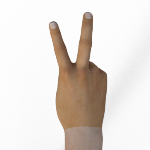


----------------------------- Joueur 2 -------------------------------
Choix : Ciseaux
Chemin de l'image & image : ./rpc/test/scissors/testscissors02-18.png


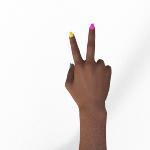


----------------------------- Résultat du tour -------------------------------
Egalité ! Score : [j1 : 0] [j2 : 0]

tour n°2
----------------------------- Joueur 1 -------------------------------
Choix : Ciseaux
Chemin de l'image & image : ./rpc/test/scissors/testscissors01-07.png


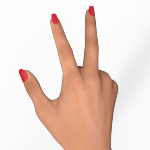


----------------------------- Joueur 2 -------------------------------
Choix : Papier
Chemin de l'image & image : ./rpc/test/paper/testpaper03-26.png


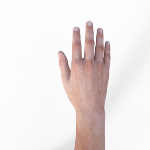


----------------------------- Résultat du tour -------------------------------
Victoire du joueur 1, score : [j1 : 1] [j2 : 0]

tour n°3
----------------------------- Joueur 1 -------------------------------
Choix : Ciseaux
Chemin de l'image & image : ./rpc/test/scissors/testscissors03-26.png


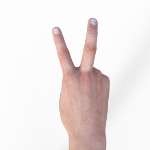


----------------------------- Joueur 2 -------------------------------
Choix : Papier
Chemin de l'image & image : ./rpc/test/paper/testpaper02-14.png


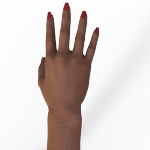


----------------------------- Résultat du tour -------------------------------
Victoire du joueur 1, score : [j1 : 2] [j2 : 0]

tour n°4
----------------------------- Joueur 1 -------------------------------
Choix : Pierre
Chemin de l'image & image : ./rpc/test/rock/testrock04-21.png


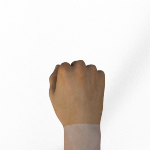


----------------------------- Joueur 2 -------------------------------
Choix : Pierre
Chemin de l'image & image : ./rpc/test/rock/testrock04-14.png


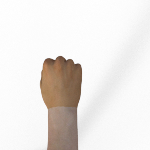


----------------------------- Résultat du tour -------------------------------
Egalité ! Score : [j1 : 2] [j2 : 0]

tour n°5
----------------------------- Joueur 1 -------------------------------
Choix : Pierre
Chemin de l'image & image : ./rpc/test/rock/testrock02-25.png


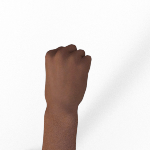


----------------------------- Joueur 2 -------------------------------
Choix : Ciseaux
Chemin de l'image & image : ./rpc/test/scissors/testscissors02-06.png


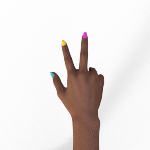


----------------------------- Résultat du tour -------------------------------
Victoire du joueur 1, score : [j1 : 3] [j2 : 0]


In [26]:
lecture_game()

## Stop execution 

Run the following cell to terminate the kernel and free memory resources:

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGTERM)